In [1]:
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Pardiso

In [59]:
# Structure to represent overset grids, comprised of overlapping grids.
mutable struct SphericalSurfaceGrid
    # r, theta, phi
    # theta is the polar angle. phi is the longitude
    # latitude and longitude are defined in a local coordinate system for each grid
    
    ntheta::Int64
    nphi::Int64
    theta::Vector{Float64}
    phi::Vector{Float64}
    dtheta::Float64
    dphi::Float64
    r::Float64 # radius
    center::Vector{Float64}
    rotation::Float64
    function SphericalSurfaceGrid(ntheta,nphi,center,rotation)
        # center defines the center of this grid
        # pad each of the grids by one cell in each direction.
        dtheta = pi/2 / (ntheta-1)
        dphi = 3*pi/2 / (nphi-1)
        thetas = LinRange(pi/4-dtheta,3*pi/4+dtheta,ntheta+2)
        phis = LinRange(-3*pi/4-dphi,3*pi/4+dphi,nphi+2)
        new(ntheta+2,nphi+2,thetas,phis,thetas[2]-thetas[1],phis[2]-phis[1],1.0,center,rotation)
    end
end



mutable struct OversetGrids
    grids::Vector{SphericalSurfaceGrid}
    function OversetGrids(ntheta,nphi)
       grid1 = SphericalSurfaceGrid(ntheta,nphi,[0.,0.],0.0)
       grid2 = SphericalSurfaceGrid(ntheta,nphi,[pi/2,pi],pi/2)
    new([grid1,grid2])
    end
end

# degrees of freedom will be laid out starting with the first grid and proceeding through the grids.
@inline node(i,j,grid::Int64,grids::OversetGrids) = (grid-1)*grids.grids[1].ntheta*grids.grids[1].nphi + (j-1)*grids.grids[grid].ntheta + i

function sph2cart(r::Float64,theta::Float64,phi::Float64)
    x = r*sin(theta)*cos(phi)
    y = r*sin(theta)*sin(phi)
    z = r*cos(theta)
    return x,y,z
end

function cart2sph(x::Float64,y::Float64,z::Float64)
   r = (x^2+y^2+z^2)^0.5
   theta = acos(z/r)
   phi   = atan(y,x)
   return r,theta,phi
end

function grid2xyz(grid::SphericalSurfaceGrid ; yang=false)
    x = zeros(grid.ntheta,grid.nphi)
    y = zeros(grid.ntheta,grid.nphi)
    z = zeros(grid.ntheta,grid.nphi)
    for i in 1:grid.ntheta
        for j in 1:grid.nphi
            xt,yt,zt = sph2cart(grid.r,grid.theta[i],grid.phi[j])
            x[i,j] = xt
            y[i,j] = yt
            z[i,j] = zt
        end
    end
    if yang
        return -x,z,y
    else
        return  x,y,z
    end
end
# define one grid to be the main grid
# in the overlapping regions, other grids will have values at overlapping coordinates prescribed.
# let r=1, 

# compute the overlaps. assemble a matrix whose rows correspond to 
# degree of freedom on grid 2, columns correspond to weights that interpolate quantities from grid 1.

# (on grid 2):
# loop over points
grids = OversetGrids(91,181)
grid2 = grids.grids[2]
grid1 = grids.grids[1]
yang_xyz = grid2xyz(grids.grids[2] ; yang=true)

enclosed = Matrix{Float64}(undef,grid2.ntheta,grid2.nphi)
match = Matrix{Bool}(undef,grid2.ntheta,grid2.nphi)
for i in 1:grid2.ntheta
    for j in 1:grid2.nphi
        x,y,z = sph2cart(grid2.r,grid2.theta[i],grid2.phi[j])
        r,t,p = cart2sph(-x,z,y)
        if t >= grid1.theta[1] && t <= grid1.theta[end] && p >= grid1.phi[1] && p <= grid1.phi[end]
                enclosed[i,j] = true
                match[i,j] = any(isapprox.(t,grid1.theta)) && any(isapprox.(p,grid1.phi))
            else
                enclosed[i,j] = false
                match[i,j] = false
            end
        
    end
end

#    transform point to grid 1 coordinates
#    compute whether this point is enclosed within grid 1.
#    no -> do nothing
#    yes -> there will be an entry in the matrix.

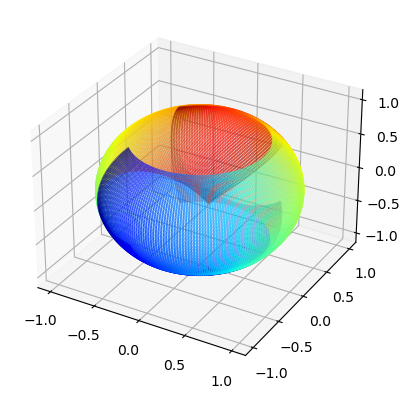

In [60]:
x,y,z = grid2xyz(grids.grids[1])

dof1 = [node(i,j,1,grids) for i in 1:grids.grids[1].ntheta, j in 1:grids.grids[1].nphi]
dof2 = [node(i,j,2,grids) for i in 1:grids.grids[1].ntheta, j in 1:grids.grids[2].nphi]

using PyPlot

fig = figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(x,y,z,c=dof1,s=0.1,cmap=get_cmap("jet"))
ax.scatter(-x,z,y,c=dof2,s=0.1,cmap=get_cmap("jet"))

fig.show()

In [57]:
enclosed
print(size(enclosed))
print(size(grid2.phi))


(91, 181)(183,)

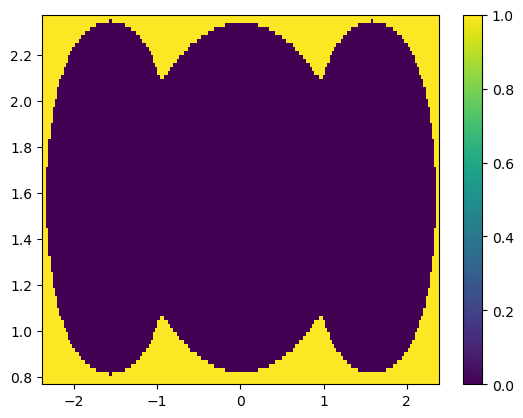

PyObject <matplotlib.colorbar.Colorbar object at 0x7f89146777f0>

In [61]:
figure()
pcolormesh(grid2.phi, grid2.theta, enclosed)
colorbar()
# figure()
# pcolormesh(match)
# colorbar()

In [10]:
test = [sph2cart(1.0,t,p) for t in grid1.theta, p in grid1.phi]


91×181 Matrix{Tuple{Float64, Float64, Float64}}:
 (-0.5, -0.5, 0.707107)             …  (-0.5, 0.5, 0.707107)
 (-0.50865, -0.50865, 0.694658)        (-0.50865, 0.50865, 0.694658)
 (-0.517145, -0.517145, 0.681998)      (-0.517145, 0.517145, 0.681998)
 (-0.525483, -0.525483, 0.669131)      (-0.525483, 0.525483, 0.669131)
 (-0.53366, -0.53366, 0.656059)        (-0.53366, 0.53366, 0.656059)
 (-0.541675, -0.541675, 0.642788)   …  (-0.541675, 0.541675, 0.642788)
 (-0.549525, -0.549525, 0.62932)       (-0.549525, 0.549525, 0.62932)
 (-0.557208, -0.557208, 0.615661)      (-0.557208, 0.557208, 0.615661)
 (-0.564721, -0.564721, 0.601815)      (-0.564721, 0.564721, 0.601815)
 (-0.572061, -0.572061, 0.587785)      (-0.572061, 0.572061, 0.587785)
 (-0.579228, -0.579228, 0.573576)   …  (-0.579228, 0.579228, 0.573576)
 (-0.586218, -0.586218, 0.559193)      (-0.586218, 0.586218, 0.559193)
 (-0.59303, -0.59303, 0.544639)        (-0.59303, 0.59303, 0.544639)
 ⋮                                  ⋱  ⋮
 (-0

In [11]:
[cart2sph(a[1],a[2],a[3]) for a in test]

91×181 Matrix{Tuple{Float64, Float64, Float64}}:
 (1.0, 0.785398, -2.35619)  …  (1.0, 0.785398, 2.35619)
 (1.0, 0.802851, -2.35619)     (1.0, 0.802851, 2.35619)
 (1.0, 0.820305, -2.35619)     (1.0, 0.820305, 2.35619)
 (1.0, 0.837758, -2.35619)     (1.0, 0.837758, 2.35619)
 (1.0, 0.855211, -2.35619)     (1.0, 0.855211, 2.35619)
 (1.0, 0.872665, -2.35619)  …  (1.0, 0.872665, 2.35619)
 (1.0, 0.890118, -2.35619)     (1.0, 0.890118, 2.35619)
 (1.0, 0.907571, -2.35619)     (1.0, 0.907571, 2.35619)
 (1.0, 0.925025, -2.35619)     (1.0, 0.925025, 2.35619)
 (1.0, 0.942478, -2.35619)     (1.0, 0.942478, 2.35619)
 (1.0, 0.959931, -2.35619)  …  (1.0, 0.959931, 2.35619)
 (1.0, 0.977384, -2.35619)     (1.0, 0.977384, 2.35619)
 (1.0, 0.994838, -2.35619)     (1.0, 0.994838, 2.35619)
 ⋮                          ⋱  ⋮
 (1.0, 2.16421, -2.35619)      (1.0, 2.16421, 2.35619)
 (1.0, 2.18166, -2.35619)   …  (1.0, 2.18166, 2.35619)
 (1.0, 2.19911, -2.35619)      (1.0, 2.19911, 2.35619)
 (1.0, 2.21657, -2.35619)

In [12]:
[(1.0,t,p) for t in grid1.theta, p in grid1.phi]

91×181 Matrix{Tuple{Float64, Float64, Float64}}:
 (1.0, 0.785398, -2.35619)  …  (1.0, 0.785398, 2.35619)
 (1.0, 0.802851, -2.35619)     (1.0, 0.802851, 2.35619)
 (1.0, 0.820305, -2.35619)     (1.0, 0.820305, 2.35619)
 (1.0, 0.837758, -2.35619)     (1.0, 0.837758, 2.35619)
 (1.0, 0.855211, -2.35619)     (1.0, 0.855211, 2.35619)
 (1.0, 0.872665, -2.35619)  …  (1.0, 0.872665, 2.35619)
 (1.0, 0.890118, -2.35619)     (1.0, 0.890118, 2.35619)
 (1.0, 0.907571, -2.35619)     (1.0, 0.907571, 2.35619)
 (1.0, 0.925025, -2.35619)     (1.0, 0.925025, 2.35619)
 (1.0, 0.942478, -2.35619)     (1.0, 0.942478, 2.35619)
 (1.0, 0.959931, -2.35619)  …  (1.0, 0.959931, 2.35619)
 (1.0, 0.977384, -2.35619)     (1.0, 0.977384, 2.35619)
 (1.0, 0.994838, -2.35619)     (1.0, 0.994838, 2.35619)
 ⋮                          ⋱  ⋮
 (1.0, 2.16421, -2.35619)      (1.0, 2.16421, 2.35619)
 (1.0, 2.18166, -2.35619)   …  (1.0, 2.18166, 2.35619)
 (1.0, 2.19911, -2.35619)      (1.0, 2.19911, 2.35619)
 (1.0, 2.21657, -2.35619)

In [13]:
dof1

91×181 Matrix{Int64}:
  1   92  183  274  365  456  547  638  …  16017  16108  16199  16290  16381
  2   93  184  275  366  457  548  639     16018  16109  16200  16291  16382
  3   94  185  276  367  458  549  640     16019  16110  16201  16292  16383
  4   95  186  277  368  459  550  641     16020  16111  16202  16293  16384
  5   96  187  278  369  460  551  642     16021  16112  16203  16294  16385
  6   97  188  279  370  461  552  643  …  16022  16113  16204  16295  16386
  7   98  189  280  371  462  553  644     16023  16114  16205  16296  16387
  8   99  190  281  372  463  554  645     16024  16115  16206  16297  16388
  9  100  191  282  373  464  555  646     16025  16116  16207  16298  16389
 10  101  192  283  374  465  556  647     16026  16117  16208  16299  16390
 11  102  193  284  375  466  557  648  …  16027  16118  16209  16300  16391
 12  103  194  285  376  467  558  649     16028  16119  16210  16301  16392
 13  104  195  286  377  468  559  650     16029  1612

In [14]:
dof2

91×181 Matrix{Int64}:
 16472  16563  16654  16745  16836  …  32488  32579  32670  32761  32852
 16473  16564  16655  16746  16837     32489  32580  32671  32762  32853
 16474  16565  16656  16747  16838     32490  32581  32672  32763  32854
 16475  16566  16657  16748  16839     32491  32582  32673  32764  32855
 16476  16567  16658  16749  16840     32492  32583  32674  32765  32856
 16477  16568  16659  16750  16841  …  32493  32584  32675  32766  32857
 16478  16569  16660  16751  16842     32494  32585  32676  32767  32858
 16479  16570  16661  16752  16843     32495  32586  32677  32768  32859
 16480  16571  16662  16753  16844     32496  32587  32678  32769  32860
 16481  16572  16663  16754  16845     32497  32588  32679  32770  32861
 16482  16573  16664  16755  16846  …  32498  32589  32680  32771  32862
 16483  16574  16665  16756  16847     32499  32590  32681  32772  32863
 16484  16575  16666  16757  16848     32500  32591  32682  32773  32864
     ⋮                       

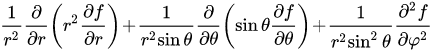

In [76]:
# discretize the poisson equation on grid1.
grid = grids.grids[1]
N = grid.ntheta*grid.nphi
row = Vector{Int64}(undef,5*N)
col = Vector{Int64}(undef,5*N)
val = Vector{Float64}(undef,5*N)
R = Vector{Float64}(undef,N)
k = 1
for j in 1:grid.nphi
    for i in 1:grid.ntheta
        this_row::Int64 = node(i,j,1,grids)
        if i==1 || i == grid.ntheta || j == 1 || j == grid.nphi
            row[k] = this_row
            col[k] = this_row
            val[k] = 1.0
            R[this_row] = 0.0
            k+=1
        else
            # center
            theta_cp = 0.5*(grid.theta[i+1]+grid.theta[i])
            theta_cm = 0.5*(grid.theta[i]  +grid.theta[i-1])
            row[k] = this_row
            col[k] = this_row
            val[k] = -1.0/grid.r^2 * sin(theta_cp)/sin(grid.theta[i])/grid.dtheta^2 +
                -1.0/grid.r^2 * sin(theta_cm)/sin(grid.theta[i])/grid.dtheta^2 +
                -1.0/grid.r^2/sin( grid.theta[i] )^2 / grid.dphi^2 +
                -1.0/grid.r^2/sin( grid.theta[i] )^2 / grid.dphi^2;
            k+=1
            # +theta
            row[k] = this_row
            col[k] = node(i+1,j,1,grids)
            val[k] = 1.0/grid.r^2 * sin(theta_cp)/sin(grid.theta[i])/grid.dtheta^2
            k+=1
            # -theta
            row[k] = this_row
            col[k] = node(i-1,j,1,grids)
            val[k] = 1.0/grid.r^2 * sin(theta_cm)/sin(grid.theta[i])/grid.dtheta^2
            k+=1
            # +phi
            row[k] = this_row
            col[k] = node(i-1,j,1,grids)
            val[k] = 1.0/grid.r^2/sin( grid.theta[i] )^2 / grid.dphi^2
            k+=1
            # -phi
            row[k] = this_row
            col[k] = node(i-1,j,1,grids)
            val[k] = 1.0/grid.r^2/sin( grid.theta[i] )^2 / grid.dphi^2
            k+=1
            R[this_row] = 1.0
        end
    end
end
row = @views row[1:k-1];
col = @views col[1:k-1];
val = @views val[1:k-1];
L = sparse(row,col,val);
solution = L\R;

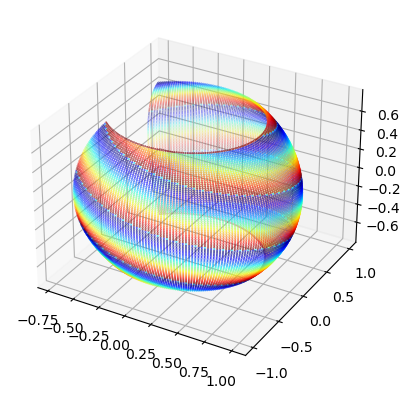

In [75]:
x,y,z = grid2xyz(grids.grids[1])

dof1 = [node(i,j,1,grids) for j in 1:grids.grids[1].nphi, i in 1:grids.grids[1].ntheta]
dof2 = [node(i,j,2,grids) for i in 1:grids.grids[1].ntheta, j in 1:grids.grids[2].nphi]

using PyPlot

fig = figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(x,y,z,c=solution,s=0.1,cmap=get_cmap("jet"))
# ax.scatter(-x,z,y,c=dof2,s=0.1,cmap=get_cmap("jet"))

fig.show()

In [72]:
size(dof1)

(93, 183)

In [77]:
size(x)

(93, 183)